In [71]:
import numpy as np
from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.table import Table
from scipy.interpolate import griddata
from photutils.aperture import *
from scipy.ndimage import gaussian_filter
from scipy.spatial import *
from sklearn.neighbors import KDTree
from astropy.table import Table
from astropy.table import vstack as vstack_table

from skimage.restoration import denoise_tv_bregman
from scipy.signal import convolve2d
from scipy.spatial import Delaunay
from scipy.spatial import cKDTree
from scipy.spatial import KDTree
from scipy.spatial import ConvexHull
import itertools


from astropy.modeling.models import Gaussian2D
from skimage import color, data, restoration
from mpl_toolkits.axes_grid1 import make_axes_locatable

#import naturalneighbor
#import _ngl
#from photutils.aperture import aperture_photometry

In [72]:
def do_kdtree_n(X):
    mytree = KDTree(X)    
    dist, ind = mytree.query(X[:1], k=3)
    print(dist,ind)
    return np.array(dist),np.array(ind)

def do_kdtree(combined_x_y_arrays,points,k=1):
    mytree = cKDTree(combined_x_y_arrays)
    dist, indexes = mytree.query(points,k=k)
    return np.array(dist),np.array(indexes)



In [73]:
from scipy.spatial import Delaunay
from scipy.spatial import cKDTree
from scipy.spatial import KDTree
from scipy.spatial import ConvexHull
import itertools

def unique2d(a):
    x, y = a.T
    b = x + y*1.0j 
    idx = np.unique(b,return_index=True)[1]
    return a[idx] 

def areaPoly(points):
    area = 0
    nPoints = len(points)
    j = nPoints - 1
    i = 0
    for point in points:
        p1 = points[i]
        p2 = points[j]
        area += (p1[0]*p2[1])
        area -= (p1[1]*p2[0])
        j = i
        i += 1

    area /= 2
    return area

def centroidPoly(points):
    nPoints = len(points)
    x = 0
    y = 0
    j = nPoints - 1
    i = 0

    for point in points:
        p1 = points[i]
        p2 = points[j]
        f = p1[0]*p2[1] - p2[0]*p1[1]
        x += (p1[0] + p2[0])*f
        y += (p1[1] + p2[1])*f
        j = i
        i += 1

    area = areaPoly(hull_points)
    f = area*6
    return [x/f, y/f]

def inter_map_IDW(phot_table_in,radius,crpix,cdelt,dim,\
                  mode='inverseDistance', sigma=1.0, radius_limit=5, \
                  resolution=1.0, min_fibers=3, slope=2.0, bad_threshold=0.1):
    phot_table=phot_table_in.copy()
    img = np.zeros([dim[1],dim[0]],dtype=np.float32)
    weights = np.zeros([dim[1],dim[0]], dtype=np.float32)
    xi = crpix[0]+cdelt[0]*np.arange(0,dim[0])
    yi = crpix[1]+cdelt[1]*np.arange(0,dim[1])
    xi,yi = np.meshgrid(xi,yi)
    phot_table['aperture_sum']=phot_table['aperture_sum']/(np.pi*radius**2)
    for phot_now in phot_table:
        if (phot_now['aperture_sum']>0):
            try:
                dist = np.sqrt((phot_now['xcenter']-xi)**2+(phot_now['ycenter']-yi)**2)
            except:
                dist = np.sqrt((phot_now['xcenter'].value-xi)**2+(phot_now['ycenter'].value-yi)**2)
            weights_0= np.exp(-0.5*np.power(dist/sigma,slope))
            weights_0[dist>radius_limit]=0
            img_0 = weights_0*phot_now['aperture_sum']#/(np.pi*radius_now**2)
            img += img_0
            weights += weights_0
            #print(phot_now['aperture_sum'],np.max(img_0),np.max(img))

    mask = (weights>0)  
    img[mask]=img[mask]/weights[mask]
#    img=gaussian_filter(img, sigma=0.25*resolution)
    return img,weights

def inter_cube_IDW(pos_table_x,pos_table_y,RSS,radius,crpix,cdelt,dim,\
                  mode='inverseDistance', sigma=1.0, radius_limit=5, \
                  resolution=1.0, min_fibers=3, slope=2.0, bad_threshold=0.1):
    cube = np.zeros([dim[2],dim[1],dim[0]],dtype=np.float32)
    weights = np.zeros([dim[1],dim[0]], dtype=np.float32)
    xi = crpix[0]+cdelt[0]*np.arange(0,dim[0])
    yi = crpix[1]+cdelt[1]*np.arange(0,dim[1])
    xi,yi = np.meshgrid(xi,yi)
    RSS=RSS/(np.pi*radius**2) # Flux is now in units of spaxel    
    for i,(pos_x,pos_y) in enumerate(zip(pos_table_x,pos_table_y)):
        if (np.sum(RSS)>0):
            dist = np.sqrt((pos_x-xi)**2+(pos_y-yi)**2)
            weights_0= np.exp(-0.5*np.power(dist/sigma,slope))
            weights_0[dist>radius_limit]=0
            cube_0 = np.ones([dim[2],dim[1],dim[0]],dtype=np.float32)*weights_0
            #print(cube_0.shape)
            cube_0_T = cube_0.T*RSS[i,:]
            #print(cube_0_T.shape)
            cube_0=cube_0_T.transpose(2,1,0)
            #print(cube_0.shape)
            cube += cube_0
            weights += weights_0
            print(f'{i}', end="\r")
            #print(phot_now['aperture_sum'],np.max(img_0),np.max(img))
    cube_weights=np.ones([dim[2],dim[1],dim[0]],dtype=np.float32)
    cube_weights=cube_weights*weights
    mask = (cube_weights>0)  
    cube[mask]=cube[mask]/cube_weights[mask]
#    img=gaussian_filter(img, sigma=0.25*resolution)
    return cube,weights
    
def inter_map(phot_table_in,radius,crpix,cdelt,dim,method='cubic'):
    phot_table=phot_table_in.copy()
    xi = crpix[0]+cdelt[0]*np.arange(0,dim[0])
    yi = crpix[1]+cdelt[1]*np.arange(0,dim[1])
    xi,yi = np.meshgrid(xi,yi)
    phot_table['aperture_sum']=phot_table['aperture_sum']/(np.pi*radius**2)
    img = griddata((phot_table['xcenter'].value, phot_table['ycenter'].value),\
                   phot_table['aperture_sum'].value, (xi, yi),method=method)
    img=gaussian_filter(img, sigma=0.25)
    return img


#  linear_interp = scipy.interpolate.griddata(known_points, known_values, tuple(grid), method='linear')

#    nn_interp = naturalneighbor.griddata(known_points, known_values, grid_ranges)




def bilinear_interpolation(x,y,x_,y_,val):

    a = 1 /((x_[1] - x_[0]) * (y_[1] - y_[0]))
    xx = np.array([[x_[1]-x],[x-x_[0]]],dtype='float32')
    f = np.array(val).reshape(2,2)
    yy = np.array([[y_[1]-y],[y-y_[0]]],dtype='float32')
    b = np.matmul(f,yy)

    return a * np.matmul(xx.T, b)        

In [74]:
def plot_four(img_in,phot_table,img,img_loop):
    fig,ax = plt.subplots(2,2,figsize=(10,8))
    try:
        plt.subplot(ax[0][0],projection=wcs)
    except:
        print('no WCS')
    ax[0][0].imshow(np.log10(img_in), cmap='gray_r', vmin=-3, vmax=0.05, origin='lower')
    try:
        plt.subplot(ax[1][0],projection=wcs)
    except:
        print('no WCS')
    ax[0][1].imshow(np.log10(img_in), cmap='gray_r', vmin=-3, vmax=-3, origin='lower')
    cm = plt.cm.get_cmap('Greys')
    ax[0][1].scatter(phot_table['xcenter'],phot_table['ycenter'],\
                     c=np.log10(phot_table['aperture_sum']/(np.pi*radius**2)),\
                     cmap=cm, vmin=-3, vmax=0.15,\
                     s=140)
    try:
        plt.subplot(ax[1][0],projection=wcs)
    except:
        print('no WCS')
    ax[1][0].imshow(np.log10(img), cmap='gray_r', vmin=-3, vmax=0.05, origin='lower')
    try:
        plt.subplot(ax[1][1],projection=wcs)
    except:
        print('no WCS')
    ax[1][1].imshow(np.log10(img_loop), cmap='gray_r', vmin=-3, vmax=0.05, origin='lower')


    ax[0][0].set_xlim([0*nx,1.0*nx])
    ax[0][0].set_ylim([0*ny,1.0*ny])

    ax[0][1].set_xlim([0*nx,1.0*nx])
    ax[0][1].set_ylim([0*ny,1.0*ny])

    ax[1][0].set_xlim([0*nx,1.0*nx])
    ax[1][0].set_ylim([0*ny,1.0*ny])

    ax[1][1].set_xlim([0*nx,1.0*nx])
    ax[1][1].set_ylim([0*ny,1.0*ny])
    
    
def plot_three(img_in,img_now,res):
    fig,ax = plt.subplots(1,3,figsize=(10,8))
    #plt.subplot(ax[0],projection=wcs)
    ax[0].imshow(np.log10(img_in), cmap='gray_r', vmin=-3, vmax=0.15, origin='lower')
    #plt.subplot(ax[1],projection=wcs)
    ax[1].imshow(np.log10(img_now), cmap='gray_r', vmin=-3, vmax=0.15, origin='lower')
    #plt.subplot(ax[2],projection=wcs)
    std=np.nanstd(res)
    ax[2].imshow(res/img_in, cmap='gray_r', vmin=-2, vmax=2, origin='lower')


    ax[0].set_xlim([0.2*nx,0.8*nx])
    ax[0].set_ylim([0.2*ny,0.8*ny])

    ax[1].set_xlim([0.2*nx,0.8*nx])
    ax[1].set_ylim([0.2*ny,0.8*ny])

    ax[2].set_xlim([0.2*nx,0.8*nx])
    ax[2].set_ylim([0.2*ny,0.8*ny])
    plt.show()


In [75]:
name = 'NGC5947'
fdir = 'data'
fdir_out = 'out'
file_rss = f'{fdir}/{name}.mos.V500.rss.fits.gz'
hdu_rss=fits.open(file_rss)

In [76]:
rss_data=hdu_rss[0].data
rss_err=hdu_rss['ERROR'].data
rss_bad=hdu_rss['BADPIX'].data
tab_rss=Table(hdu_rss['POSTABLE'].data)
fsize=2.68/2
radius=fsize
(ny_rss,nx_rss)=rss_data.shape
wavelength=hdu_rss[0].header['CRVAL1']+hdu_rss[0].header['CDELT1']*(arange(0,nx_rss))

In [77]:
#
# Refine the error map
#
med_err = np.nanmedian(rss_err)
std_err = np.nanstd(rss_err[rss_err<3*med_err])
rss_err[rss_err>(med_err+3*std_err)]=med_err


In [78]:
#primhdu = fits.PrimaryHDU(data=rss_err_new)
#hdulist=fits.HDUList([primhdu])
#outfile=f'out/{name}.rss_err_new.fits.gz'
#hdulist.writeto(outfile,overwrite=True)


In [79]:
print(tab_rss.columns)

<TableColumns names=('X_Position','Y_Position','GoodFiber','FiberType')>


In [80]:
pt_file=f'{fdir}/{name}.mos.V500.pt.txt'
#pt_file="/home/sanchez/tmp/web_20181105/UGC02225.mos.V500.pt.txt"#UGC02225.mos.V500.pt.txt"
#pt_file="/disk-a/sanchez/ppak/legacy/DATA/SSP/legacy/mos_new.pt.txt"
with open(pt_file) as fp:
    line = fp.readline()
    pt_shape=line.split()
    pt_x=[]
    pt_y=[]
    while line:
        line = fp.readline()
        pt_pos = line.split()
        if (len(pt_pos)>0):
            pt_x.append(float(pt_pos[1]))
            pt_y.append(float(pt_pos[2]))

pt_x=np.array(pt_x)
pt_y=np.array(pt_y)
#print(pt_x,pt_y)
print(len(pt_x))
#print(pt_x)   
points=np.zeros((len(pt_x),2))
points[:,0]=pt_x
points[:,1]=pt_y


x_min = np.min(pt_x)-fsize
x_max = np.max(pt_x)+fsize
y_min = np.min(pt_y)-fsize
y_max = np.max(pt_y)+fsize
pix_size=0.5
nx = int((x_max-x_min)/pix_size)
ny = int((y_max-y_min)/pix_size)
dim = np.array([nx,ny])

pt_x_spax=(pt_x-x_min)/pix_size
pt_y_spax=(pt_y-y_min)/pix_size

points_WCS=points.copy()
points_WCS[:,0]=pt_x_spax
points_WCS[:,1]=pt_y_spax
slope=2.5


993


In [81]:
#
# We look for those spectra affected by vignetting
#
zero_slice = np.zeros((len(pt_x)))
ind_spec = np.arange(0,len(pt_x))
#print(zero_slice.shape)
for i in arange(0,len(pt_x)):
    #zero_slice[i]=
    zero_slice[i]=rss_data[i,:].tolist().count(0)

mask_vig = (zero_slice>10)
#print(len(zero_slice[mask_vig]))
#print(points[:,0])
nk=6
dist_vig, ind_vig = do_kdtree(points[mask_vig],points[~mask_vig],k=nk)
#print(ind_vig)


In [82]:
print(ind_vig[0,0])

107


In [83]:
ind_spec_vig = ind_spec[mask_vig]
ind_spec_nvig = ind_spec[~mask_vig]

0.047322206 0.08866104


(-0.02366110309958458, 0.10639324486255645)

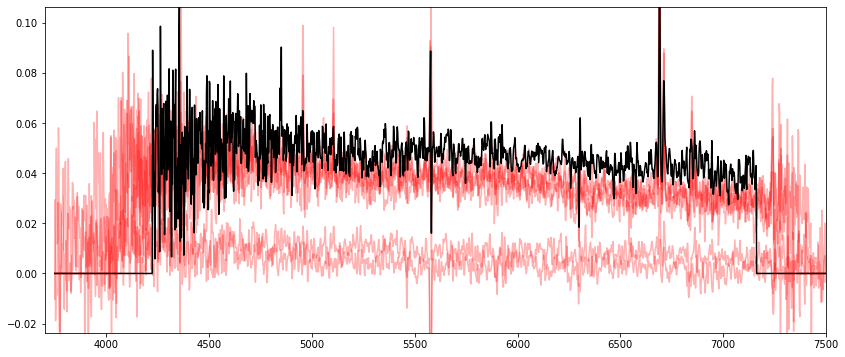

In [84]:
i_vig=0
n_spec_vig=ind_spec_vig[i_vig]
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
(ny_rss,nx_rss)=rss_data.shape
med=np.nanmedian(rss_data[n_spec_vig,int(nx_rss*0.3):int(nx_rss*0.7)])
max_v=np.nanmax(rss_data[n_spec_vig,int(nx_rss*0.4):int(nx_rss*0.6)])

for j in arange(0,nk):
    n_spec_nvig=ind_vig[n_spec_vig,j]
    ax.plot(wavelength,rss_data[n_spec_nvig,:],alpha=0.3,color='red')

    
ax.plot(wavelength,rss_data[n_spec_vig,:],color='black')
    
ax.set_xlim(3700,7500)
print(med,max_v)
ax.set_ylim(-0.5*med,1.2*max_v)
#ax.set_ylim(-45,45)
#print(ind_vig)

(-45.0, 45.0)

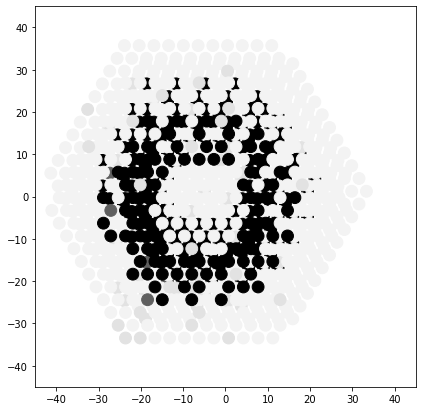

In [85]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cm = plt.cm.get_cmap('Greys')
ax.scatter(pt_x,pt_y,c=zero_slice,\
              cmap=cm, vmin=0, vmax=10,\
             s=140)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-45,45)
ax.set_ylim(-45,45)




In [126]:
#img_org_075,weights = inter_map_IDW(phot_table,radius,[0,0],[1,1],[nx,ny],slope=slope,\
#                            radius_limit=3.5/pix_size)


cube_org,weights_org=inter_cube_IDW(pt_x_spax,pt_y_spax,rss_data,radius,\
                                    [0,0],[1,1],[nx,ny,nx_rss],\
                                    mode='inverseDistance', sigma=radius, radius_limit=1.5*radius/pix_size,
                                    resolution=1.0, min_fibers=3, slope=slope, bad_threshold=0.1)

In [87]:
cube_var,weights_var=inter_cube_IDW(pt_x_spax,pt_y_spax,rss_err**2,radius,\
                                    [0,0],[1,1],[nx,ny,nx_rss],\
                                    mode='inverseDistance', sigma=radius, radius_limit=1.5*radius/pix_size,
                                    resolution=1.0, min_fibers=3, slope=slope, bad_threshold=0.1)

In [127]:
hdr=hdu_rss[0].header.copy()
hdr['CRVAL3']=hdu_rss[0].header['CRVAL1']
hdr['CRPIX3']=hdu_rss[0].header['CRPIX1']
hdr['CDELT3']=hdu_rss[0].header['CDELT1']
hdr['CRVAL1']=0
hdr['CRPIX1']=1
hdr['CDELT1']=pix_size
hdr['CRVAL2']=0
hdr['CRPIX2']=1
hdr['CDELT2']=pix_size

primhdu = fits.PrimaryHDU(data=cube_org,header=hdr)
hdulist=fits.HDUList([primhdu])
outfile=f'out/{name}.cube.fits.gz'
hdulist.writeto(outfile,overwrite=True)

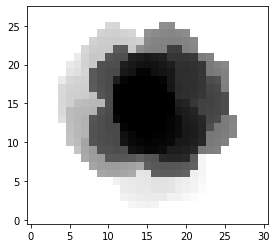

In [147]:
#
# Assumed input FWHM=1.0"
#
FWHM_in = 1.5
def Gaussian2D_map(nx,ny,A,xc,yc,sigma_x,sigma_y,theta=0):
    xi = np.arange(0,nx)
    yi = np.arange(0,ny)
    xi,yi = np.meshgrid(xi,yi)    
    img = Gaussian2D(A, xc, yc, sigma_x, sigma_y, theta=theta)(xi, yi)
    return img
sigma_FWHM=FWHM_in/pix_size/2.354
new_radius=1
aper = CircularAperture(points_WCS, radius)
new_aper = CircularAperture(points_WCS, new_radius)
#aper_center = CircularAperture(points_WCS, new_radius)
img_Gauss=Gaussian2D_map(nx,ny,1,nx*0.5,ny*0.5,sigma_FWHM,sigma_FWHM,0)
phot_Gauss_org = aperture_photometry(img_Gauss, aper,\
                                           method='subpixel',subpixels=5)
img_Gauss_r,weights_Gauss_r = inter_map_IDW(phot_Gauss_org,radius,[0,0],[1,1],[nx,ny],sigma=radius/pix_size,\
                                            slope=slope,\
                            radius_limit=1.5*radius/pix_size)
img_psf_r = img_Gauss_r[int(0.4*ny):int(0.6*ny),int(0.4*nx):int(0.6*nx)]
plt.imshow(np.log10(img_psf_r), cmap='gray_r', vmin=-10, vmax=-1, origin='lower')

In [1]:
n_mc=10
plot=0

cube_dec=cube_org.copy()
cube_err=cube_org.copy()
(nz_c,ny_c,nx_c)=cube_dec.shape
nz_0=0
nz_1=nz_c

f_e = 0.005

#nz_0=1132
#nz_1=1135
#plot=1

for iz in arange(nz_0,nz_1):
    cube_mc = np.zeros([n_mc,ny_c,nx_c],dtype=np.float32)
    for i_mc in arange(0,n_mc):
        img_org=cube_org[iz,:,:]+gaussian_filter(np.sqrt(cube_var[iz,:,:]),sigma=fsize/pix_size)*(np.random.random([ny_c,nx_c])-0.5)
        img_loop_in = img_org+img_org.max() * 1E-5 * np.random.random(img_org.shape)
        #img_loop_in = img_org+np.nanmedian(img_org) * 1E-5 * np.random.random(img_org.shape)
        img_loop_dec = restoration.richardson_lucy(img_loop_in, img_psf_r,10,clip=True,filter_epsilon=f_e)#, num_iter=30)
        #img_loop_dec, _ = restoration.unsupervised_wiener(img_loop_in, img_psf_r)
        img_loop_dec = gaussian_filter(img_loop_dec,sigma=FWHM_in/pix_size/2.354)#*np.sum(img_Gauss)
        flux_ratio = np.sum(img_loop_in)/np.sum(img_loop_dec)
        img_loop_dec = img_loop_dec*flux_ratio
        img_loop_dec[img_org==0]=0
        cube_mc[i_mc,:,:]=img_loop_dec
    cube_dec[iz,:,:]=np.nanmean(cube_mc,axis=0)
    cube_err[iz,:,:]=np.nanstd(cube_mc,axis=0)
    print(f'{iz}',end='\r')
    if (plot==1):
        fig,ax = plt.subplots(1,2,figsize=(10,8))
        ax[0].imshow(np.log10(img_org), cmap='gray_r', vmin=-3, vmax=-0.5, origin='lower')
        ax[0].set_xlim([0*nx,1.0*nx])
        ax[0].set_ylim([0*ny,1.0*ny])
        ax[1].imshow(np.log10(img_loop_dec), cmap='gray_r', vmin=-3, vmax=-0.5, origin='lower')
        ax[1].set_xlim([0*nx,1.0*nx])
        ax[1].set_ylim([0*ny,1.0*ny])
        plt.show()


NameError: name 'cube_org' is not defined

In [150]:
primhdu = fits.PrimaryHDU(data=cube_dec,header=hdr)
hdulist=fits.HDUList([primhdu])
outfile=f'out/{name}.dcube_new.fits.gz'
hdulist.writeto(outfile,overwrite=True)
print('DONE')

DONE


# FURTHER TESTS BELOW!

In [ ]:
#
# Tests using a flat... it did not work!
#

In [ ]:
#
# Other method
#
n0 = int(0.45*nz_c)
n1 = int(0.55*nz_c)
img_slice = rss_data[:,n0:n1].sum(axis=1)/(n1-n0)
phot_table=Table()
phot_table.add_column(pt_x_spax,name='xcenter')
phot_table.add_column(pt_y_spax,name='ycenter')
phot_table.add_column(img_slice,name='aperture_sum')
radius=fsize
img_org,weights = inter_map_IDW(phot_table,radius,[0,0],[1,1],[nx_c,ny_c],slope=slope,\
                            radius_limit=3.5/pix_size)

In [ ]:
plt.imshow(np.log10(img_org), cmap='gray_r', vmin=-3, vmax=-1, origin='lower')

In [ ]:
img_org_copy=img_org.copy()
img_org_copy[img_org_copy==0]=0.5*np.median(img_org[img_org>0])
img_loop_in = img_org_copy+img_org_copy.max() * 1E-5 * np.random.random(img_org_copy.shape)
img_loop_dec = restoration.richardson_lucy(img_loop_in, img_psf_r,10)#, num_iter=30)
img_loop_dec = gaussian_filter(img_loop_dec,sigma=0.5)#*np.sum(img_Gauss)
flux_ratio = np.sum(img_loop_in)/np.sum(img_loop_dec)
img_loop_dec = img_loop_dec*flux_ratio
img_loop_dec[img_org==0]=0
cube_dec[iz,:,:]=img_loop_dec
print(f'{iz}',end='\r')
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(np.log10(img_org), cmap='gray_r', vmin=-3, vmax=-0.5, origin='lower')
ax[0].set_xlim([0*nx,1.0*nx])
ax[0].set_ylim([0*ny,1.0*ny])
ax[1].imshow(np.log10(img_loop_dec), cmap='gray_r', vmin=-3, vmax=-0.5, origin='lower')
ax[1].set_xlim([0*nx,1.0*nx])
ax[1].set_ylim([0*ny,1.0*ny])
plt.show()

In [ ]:
flat_img = img_loop_dec/img_org
flat_img[img_org==0]=0
cube_flatted = cube_org*flat_img
primhdu = fits.PrimaryHDU(data=cube_flatted,header=hdr)
hdulist=fits.HDUList([primhdu])
outfile=f'out/{name}.fcube.fits.gz'
hdulist.writeto(outfile,overwrite=True)
#flat_cube=np.ones([dim[2],dim[1],dim[0]],dtype=np.float32)
#flat_cube=cube_weights*weights


In [ ]:
primhdu = fits.PrimaryHDU(data=img_org_copy)
hdulist=fits.HDUList([primhdu])
outfile=f'out/{name}.img_org.fits.gz'
hdulist.writeto(outfile,overwrite=True)

In [ ]:
primhdu = fits.PrimaryHDU(data=img_loop_dec)
hdulist=fits.HDUList([primhdu])
outfile=f'out/{name}.img_loop_dec.fits.gz'
hdulist.writeto(outfile,overwrite=True)